In [1]:
from freecond_src.freecond import FreeCondPipeline
import torch

device = "cuda"
torch.cuda.set_device(1)
"""
pipe = FreeCondPipeline.from_pretrained(
    'Lykon/dreamshaper-8-inpainting',
    variant="fp16",
    torch_dtype=torch.float16,
).to(device)
"""

pipe = FreeCondPipeline.from_pretrained(
 "sd-legacy/stable-diffusion-inpainting",
    torch_dtype=torch.float16,
).to(device)

"""
pipe = FreeCondPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)
"""

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /nfs/home/bluedyee/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /nfs/home/bluedyee/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/nfs/home/bluedyee/miniconda3/envs/hdpainter/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/nfs/home/bluedyee/miniconda3/envs/hdpainter/lib/python3.9/site-packages/transfor

'\npipe = FreeCondPipeline.from_pretrained(\n    "stabilityai/stable-diffusion-2-inpainting",\n    torch_dtype=torch.float16,\n).to(device)\n'

In [2]:
from PIL import ImageFont
from PIL import ImageDraw 

def add_font(image, text="hi", font_size=20, position=(0,0), color=(0,255,0)):
    # Step 2: Create an ImageDraw object to draw on the image
    image=image.convert("RGB")
    draw = ImageDraw.Draw(image)
    # Optional: Load a custom font (e.g., TrueType font) if you want a specific font
    # font = ImageFont.truetype("arial.ttf", size=40)  # Ensure the .ttf file is available
    # Load a custom font with the specified font size
    try:
        # Ensure the .ttf file is available in your system or provide the full path
        font = ImageFont.truetype("Arial.ttf", font_size)
    except IOError:
        # If the custom font is not found, fall back to the default font
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    # Step 4: Write text on the image
    draw.text(position, text, fill=color, font=font)
    return image


# Vis with prompt control

Activating VIS Attention Control...
# Visualize cross attention (1, 3, 5, 7... layers) = True
# Visualize self attention (0, 2, 4, 6 ... layers)= False


  0%|          | 0/50 [00:00<?, ?it/s]

Activating VIS Attention Control...
# Visualize cross attention (1, 3, 5, 7... layers) = True
# Visualize self attention (0, 2, 4, 6 ... layers)= False


  0%|          | 0/50 [00:00<?, ?it/s]

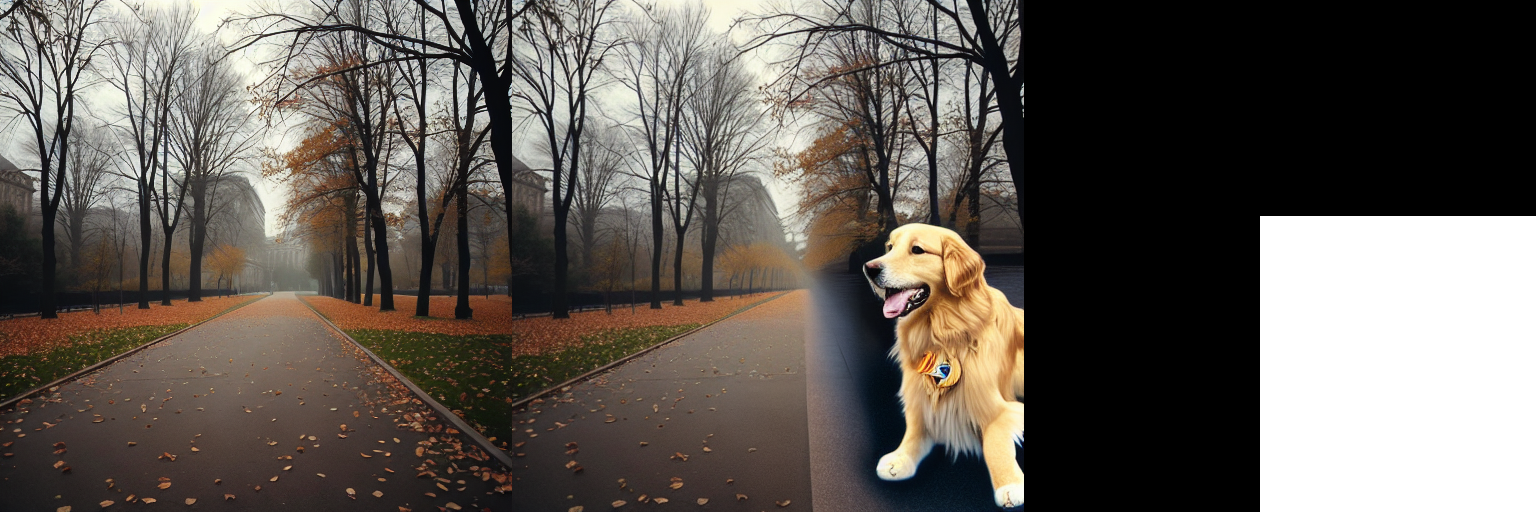

In [9]:
from PIL import Image
import pandas as pd
import os
from diffusers import DDIMScheduler
from diffusers.utils import load_image, make_image_grid

from freecond_src.vis_attn_control import VISAttentionControl, regiter_attention_editor_diffusers
pipe.scheduler=DDIMScheduler.from_config(pipe.scheduler.config)

###
idx=14
nprompt="word, bad quality, bad anatomy, ugly, mutation, blurry, error"
SEED=777
data_dir="./data/FCIBench"
df=pd.read_csv(os.path.join(data_dir, "FCinpaint_bench_info.csv"), index_col=None)
for index, data in df[idx:idx+1].iterrows():
    prompt=data["prompt"]
    image_path=os.path.join(data_dir,data["image"])
    #image_path="masks/gray_mask.png"
    mask_path=os.path.join(data_dir,data["mask"])
    mask_path="masks/black_mask.png"
    init_image=Image.open(image_path).resize((512,512)).convert("RGB")
    mask=Image.open(mask_path).resize((512,512))
    condition_mask, c_masked_image_latents = pipe.prepare_mask_condition(init_image,mask)
    torch.manual_seed(SEED)
    n_editor = VISAttentionControl(start_step=0,end_step=50, start_layer=0, end_layer=16, vis_self=False, vis_cross=True,vis_cross_token=True)
    regiter_attention_editor_diffusers(pipe, n_editor)
    out_normal=pipe.normal_forward(prompt, init_image, condition_mask, c_masked_image_latents,
                                    guidance_scale=15, negative_prompt=nprompt, scheduler_step="ddim",demo=False)
    

    #mask_path=os.path.join(data_dir,data["mask"])
    mask_path="masks/right_bot_mask.png"
    init_image=Image.open(image_path).resize((512,512)).convert("RGB")
    mask=Image.open(mask_path).resize((512,512))
    condition_mask, c_masked_image_latents = pipe.prepare_mask_condition(init_image,mask)
    editor = VISAttentionControl(start_step=0,end_step=50, start_layer=0, end_layer=16, vis_self=False, vis_cross=True,vis_cross_token=True)
    regiter_attention_editor_diffusers(pipe, editor)
    torch.manual_seed(SEED)
    out_free=pipe.normal_forward(prompt, init_image, condition_mask, c_masked_image_latents,
                                    guidance_scale=15, negative_prompt=nprompt, scheduler_step="ddim",demo=False)
make_image_grid([out_normal[0],out_free[0],mask],rows=1,cols=3)

In [10]:
###
token_idx=5
###

text_inputs = pipe.tokenizer(
    prompt,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
text_input_ids = text_inputs.input_ids
token=pipe.tokenizer.decode(text_input_ids[0][token_idx])
token

'astronaut'

In [11]:
def find_eot(text_ids):
    for cur_idx in range(77):
        token = pipe.tokenizer.decode(text_ids[cur_idx])
        if token=='<|endoftext|>':
            return cur_idx
    return 76
find_eot(text_input_ids[0])

11

# Channel-wise Influence indicator (all timesteps)

(-8.0, 8.0)

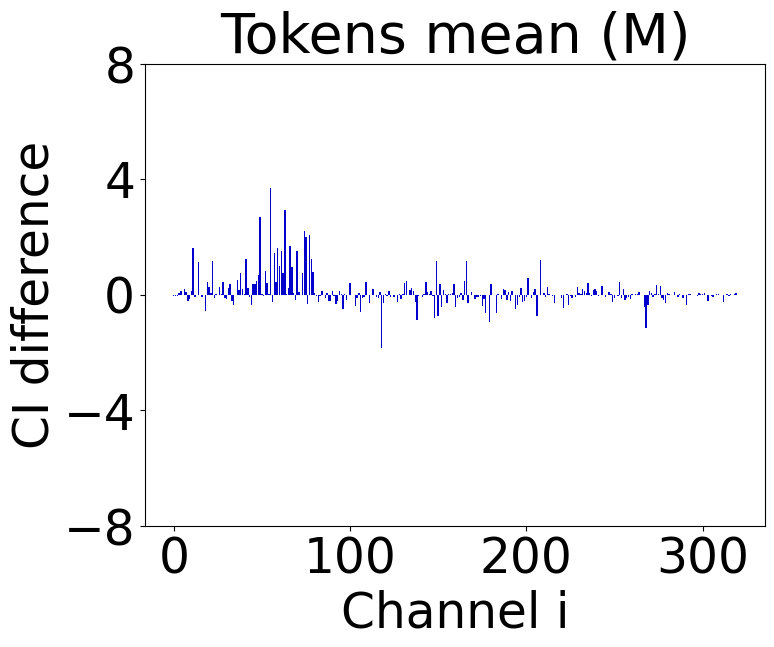

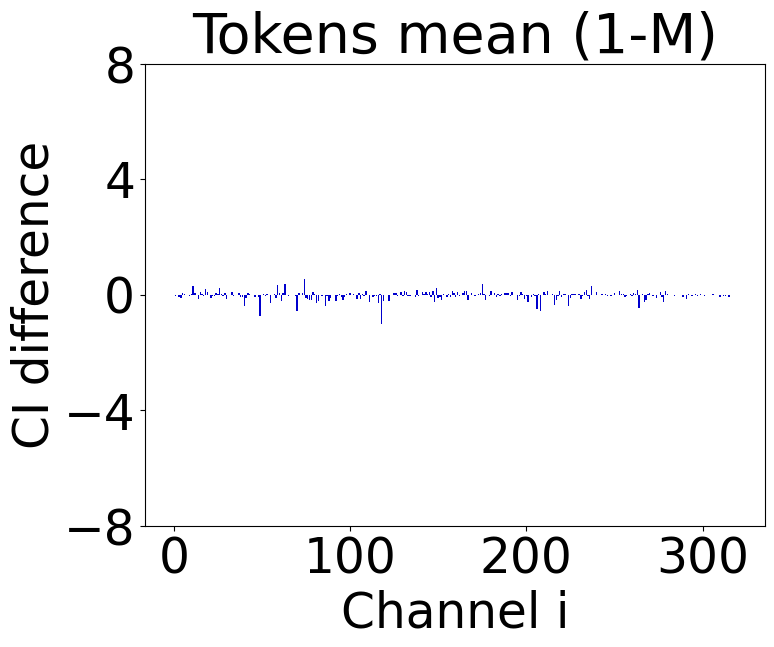

In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
# in mask
mask=condition_mask[0,0]
flat_mask=mask.flatten().cpu()
mask_indices_true=torch.where(flat_mask==True)[0]
mask_indices_false=torch.where(flat_mask==False)[0]
layer=1
show_k=3
indicator="c"

class avg_metrics:
    def __init__(self):
        self.cur_mean=0
        self.cur_sample=0
    def update(self,val):
        self.cur_sample += 1
        self.cur_mean = val/self.cur_sample + self.cur_mean*((self.cur_sample-1)/self.cur_sample)
        return self.cur_mean
metric1 = avg_metrics()
metric2 = avg_metrics()

text_inputs = pipe.tokenizer(
    prompt,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
text_input_ids = text_inputs.input_ids

eot_token_idx=find_eot(text_input_ids[0])
for step in range(50):
    for token_idx in range(1,eot_token_idx):

        token=pipe.tokenizer.decode(text_input_ids[0][token_idx])
        token_feature_k=editor.cross_token_k_dict[indicator][step][layer]
        token_feature_q_1 = n_editor.cross_token_q_dict[indicator][step][layer]
        token_feature_q_2 = editor.cross_token_q_dict[indicator][step][layer]
        sim_matrix_1=token_feature_q_1*token_feature_k[:,token_idx:token_idx+1,:]
        sim_matrix_2=token_feature_q_2*token_feature_k[:,token_idx:token_idx+1,:]
        sim_diff = sim_matrix_2-sim_matrix_1
        sim_diff=sim_diff.permute(1,0,2)
        sim_shape=sim_diff.shape
        sim_diff=sim_diff.reshape(sim_shape[0],-1)

        channel_wise_sum=torch.mean(sim_diff[mask_indices_true],dim=0)
        metric1.update(channel_wise_sum)
        channel_wise_sum=torch.mean(sim_diff[mask_indices_false],dim=0)
        metric2.update(channel_wise_sum)



plt.figure(figsize=(8, 6))

data = metric1.cur_mean
index = np.arange(len(data))
plt.bar(index, data, color='mediumblue')
plt.xlabel('Channel i',fontsize=35)
plt.ylabel("CI difference",fontsize=35)
plt.title(f'Tokens mean (M)',fontsize=40)
plt.xticks([0,100,200,300],fontsize=35)                         
plt.yticks([-8,-4,0,4,8],fontsize=35)
plt.ylim(-8,8)

plt.figure(figsize=(8, 6))
data = metric2.cur_mean
index = np.arange(len(data))
plt.bar(index, data, color='mediumblue')
plt.xlabel('Channel i',fontsize=35)
plt.ylabel("CI difference",fontsize=35)
plt.title(f'Tokens mean (1-M)',fontsize=40)
plt.xticks([0,100,200,300],fontsize=35)                         
plt.yticks([-8,-4,0,4,8],fontsize=35)
plt.ylim(-8,8)

# All data

100%|██████████| 600/600 [2:19:56<00:00, 13.99s/it]


(-8.0, 8.0)

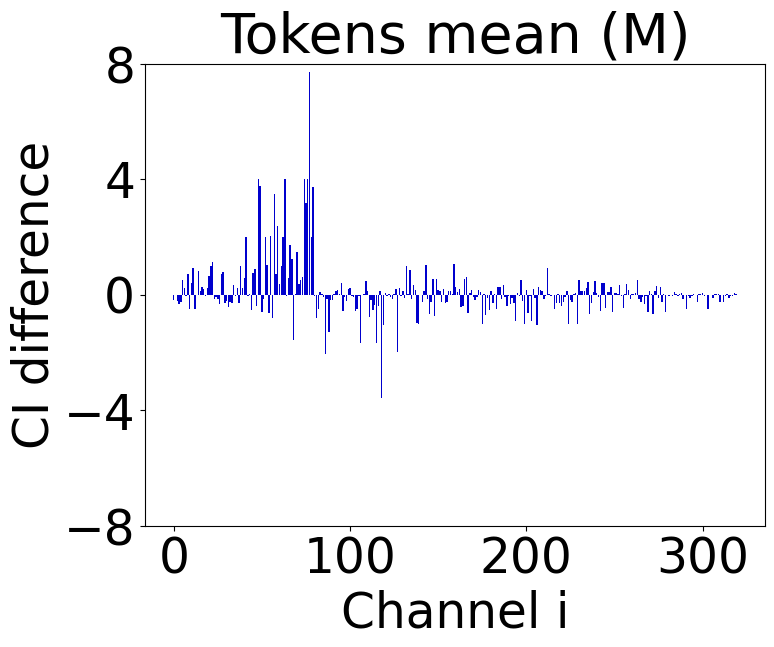

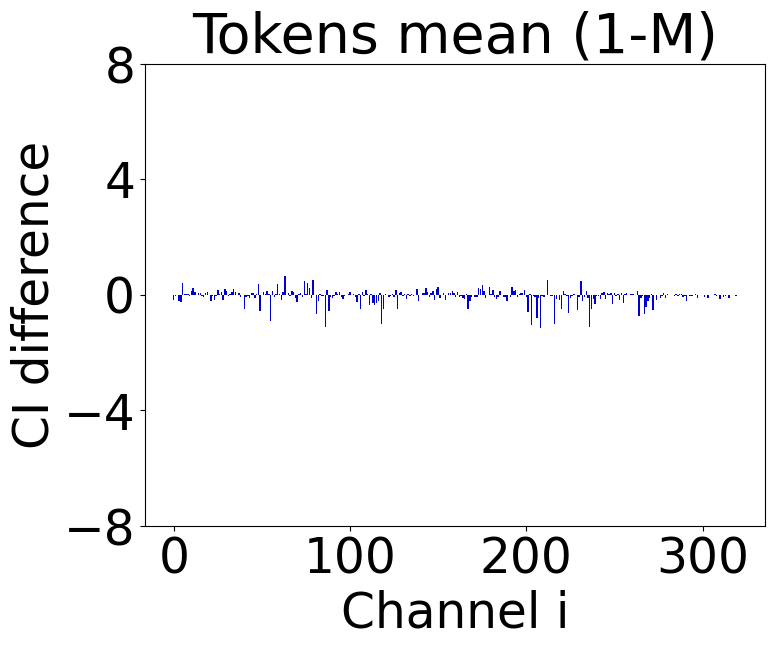

In [17]:
from IPython.display import clear_output
from tqdm import tqdm
nprompt="word, bad quality, bad anatomy, ugly, mutation, blurry, error"
SEED=777
data_dir="./data/FCIBench"
metric1 = avg_metrics()
metric2 = avg_metrics()
max_idx=600
df=pd.read_csv(os.path.join(data_dir, "FCinpaint_bench_info.csv"), index_col=None)
for index, data in tqdm(df[:max_idx].iterrows(),total=max_idx):
    print("index", index)
    prompt=data["prompt"]
    image_path=os.path.join(data_dir,data["image"])

    mask_path="masks/black_mask.png"
    init_image=Image.open(image_path).resize((512,512)).convert("RGB")
    mask=Image.open(mask_path).resize((512,512))
    condition_mask, c_masked_image_latents = pipe.prepare_mask_condition(init_image,mask)
    torch.manual_seed(SEED)
    n_editor = VISAttentionControl(start_step=0,end_step=50, start_layer=0, end_layer=16, vis_self=False, vis_cross=True,vis_cross_token=True)
    regiter_attention_editor_diffusers(pipe, n_editor)
    out_normal=pipe.normal_forward(prompt, init_image, condition_mask, c_masked_image_latents,
                                    guidance_scale=15, negative_prompt=nprompt, scheduler_step="ddim",demo=False)
    

    mask_path=os.path.join(data_dir,data["mask"])
    #mask_path="masks/right_bot_mask.png"
    init_image=Image.open(image_path).resize((512,512)).convert("RGB")
    mask=Image.open(mask_path).resize((512,512))
    condition_mask, c_masked_image_latents = pipe.prepare_mask_condition(init_image,mask)
    editor = VISAttentionControl(start_step=0,end_step=50, start_layer=0, end_layer=16, vis_self=False, vis_cross=True,vis_cross_token=True)
    regiter_attention_editor_diffusers(pipe, editor)
    torch.manual_seed(SEED)
    out_free=pipe.normal_forward(prompt, init_image, condition_mask, c_masked_image_latents,
                                    guidance_scale=15, negative_prompt=nprompt, scheduler_step="ddim",demo=False)
    

    mask=condition_mask[0,0]
    flat_mask=mask.flatten().cpu()
    mask_indices_true=torch.where(flat_mask==True)[0]
    mask_indices_false=torch.where(flat_mask==False)[0]


    text_inputs = pipe.tokenizer(
    prompt,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids

    eot_token_idx=find_eot(text_input_ids[0])

    for step in range(50):
        for token_idx in range(1,eot_token_idx):

            token=pipe.tokenizer.decode(text_input_ids[0][token_idx])
            token_feature_k=editor.cross_token_k_dict[indicator][step][layer]
            token_feature_q_1 = n_editor.cross_token_q_dict[indicator][step][layer]
            token_feature_q_2 = editor.cross_token_q_dict[indicator][step][layer]
            sim_matrix_1=token_feature_q_1*token_feature_k[:,token_idx:token_idx+1,:]
            sim_matrix_2=token_feature_q_2*token_feature_k[:,token_idx:token_idx+1,:]
            sim_diff = sim_matrix_2-sim_matrix_1
            sim_diff=sim_diff.permute(1,0,2)
            sim_shape=sim_diff.shape
            sim_diff=sim_diff.reshape(sim_shape[0],-1)

            channel_wise_sum=torch.mean(sim_diff[mask_indices_true],dim=0)
            metric1.update(channel_wise_sum)
            channel_wise_sum=torch.mean(sim_diff[mask_indices_false],dim=0)
            metric2.update(channel_wise_sum)
    clear_output(wait=True)

plt.figure(figsize=(8, 6))

data = metric1.cur_mean
index = np.arange(len(data))
plt.bar(index, data, color='mediumblue')
plt.xlabel('Channel i',fontsize=35)
plt.ylabel("CI difference",fontsize=35)
plt.title(f'Tokens mean (M)',fontsize=40)
plt.xticks([0,100,200,300],fontsize=35)                         
plt.yticks([-8,-4,0,4,8],fontsize=35)
plt.ylim(-8,8)

plt.figure(figsize=(8, 6))
data = metric2.cur_mean
index = np.arange(len(data))
plt.bar(index, data, color='mediumblue')
plt.xlabel('Channel i',fontsize=35)
plt.ylabel("CI difference",fontsize=35)
plt.title(f'Tokens mean (1-M)',fontsize=40)
plt.xticks([0,100,200,300],fontsize=35)                         
plt.yticks([-8,-4,0,4,8],fontsize=35)
plt.ylim(-8,8)